# Mutual information exploration

In [20]:
import numpy as np
import xarray as xr

from tqdm.notebook import tqdm

from frites.simulations import sim_multi_suj_ephy, sim_single_suj_ephy
from frites.dataset import DatasetEphy
from frites.workflow import WfMi
from frites.conn import conn_dfc, define_windows
from cfutils import set_mpl_style
from cfutils.config import PALETTE_RGB_N
from matplotlib import pyplot as plt
set_mpl_style()

np.random.seed(0)

### Continuous;Continuous

In [19]:
from frites.simulations import sim_mi_cc

In [20]:
modality = "meeg"
n_subjects = 5
n_epochs = 400
n_times = 100
x, roi, time = sim_multi_suj_ephy(
    n_subjects=n_subjects,
    n_epochs=n_epochs,
    n_times=n_times,
    modality=modality,
    random_state=0,
)

In [21]:
sl = slice(40, 60)
y = [x[k][..., sl].mean(axis=(1, 2)) for k in range(len(x))]
dt = DatasetEphy(x.copy(), y=y, roi=roi, times=time)

Definition of an electrophysiological dataset
    Dataset composed of 5 subjects / sessions
    At least False subjects / roi required
    Supported MI definition I(x; y (continuous)) (cc)


Gaussian Copula Mutual Information Estimator (mi_type=cc, copnorm=False, biascorrect=True, demeaned=False)
Definition of a non-parametric statistical workflow
Workflow for computing mutual information (inference=ffx, mi_type=cc, copnorm=True)
    Evaluate true and permuted mi (n_perm=0, n_jobs=-1)
100%|██████████| Estimating MI : 1/1 [00:00<00:00,   14.30it/s]


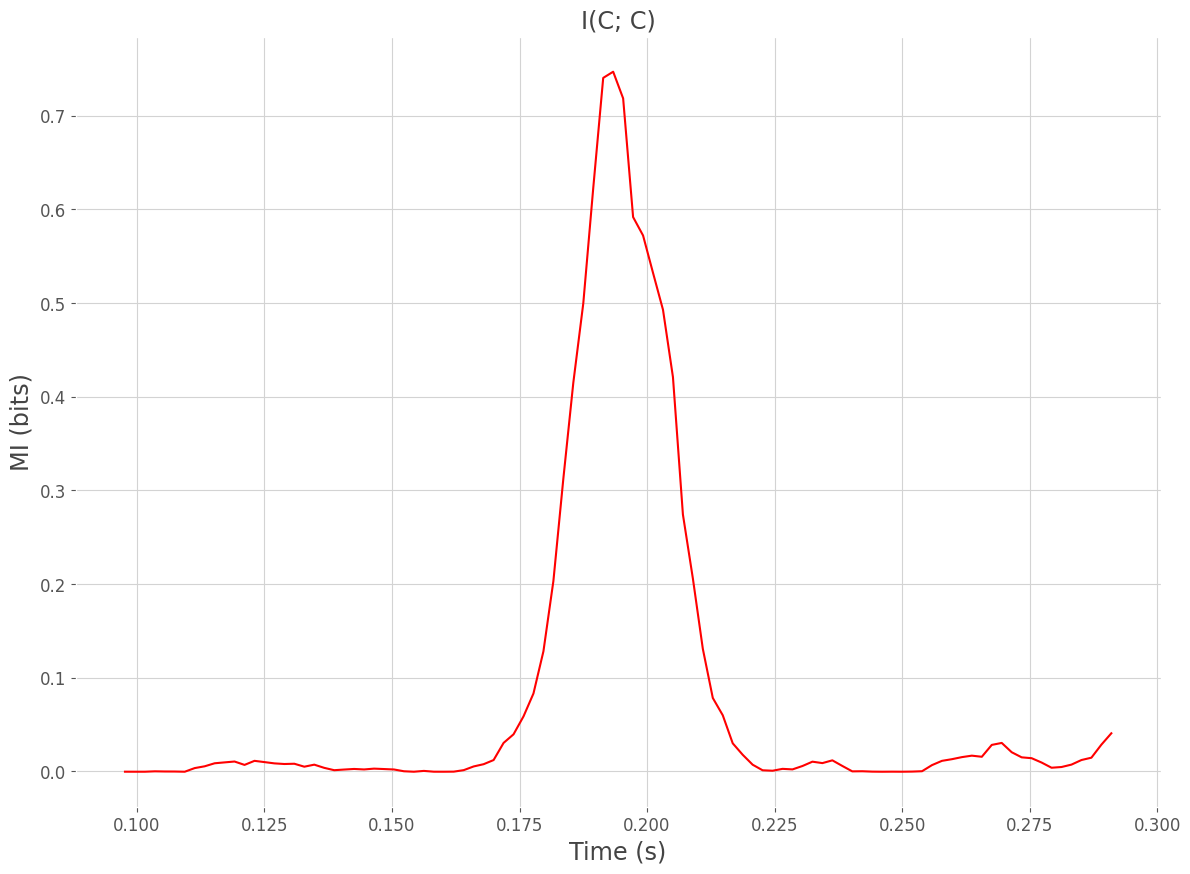

In [24]:
# mutual information type ('cc' = continuous / continuous)
mi_type = "cc"

# define the workflow
wf = WfMi(mi_type, inference="ffx")
# compute the mutual information without permutations
mi, _ = wf.fit(dt, mcp=None)

# plot the information shared between the data and the regressor y
plt.plot(time, mi)
plt.xlabel("Time (s)"), plt.ylabel("MI (bits)")
plt.title("I(C; C)")
plt.show()


Definition of an electrophysiological dataset
    Dataset composed of 5 subjects / sessions
    At least False subjects / roi required
    Supported MI definition I(x; y (continuous)) (cc)
Gaussian Copula Mutual Information Estimator (mi_type=cc, copnorm=False, biascorrect=True, demeaned=False)
Definition of a non-parametric statistical workflow
Workflow for computing mutual information (inference=ffx, mi_type=cc, copnorm=True)
    Evaluate true and permuted mi (n_perm=200, n_jobs=1)
100%|██████████| Estimating MI : 1/1 [01:22<00:00,   82.11s/it]
    Fixed-effect inference (FFX)
    Cluster forming threshold (tail=1; alpha=0.05; tfce=True)
    Inference at cluster-level
    Cluster detection (threshold={'start': 0.0010730908, 'step': 0.00022904047742486, 'e_power': 0.5, 'h_power': 2}; tail=1)
Definition of an electrophysiological dataset
    Dataset composed of 5 subjects / sessions
    At least False subjects / roi required
    Supported MI definition I(x; y (continuous)) (cc)
Gaussia

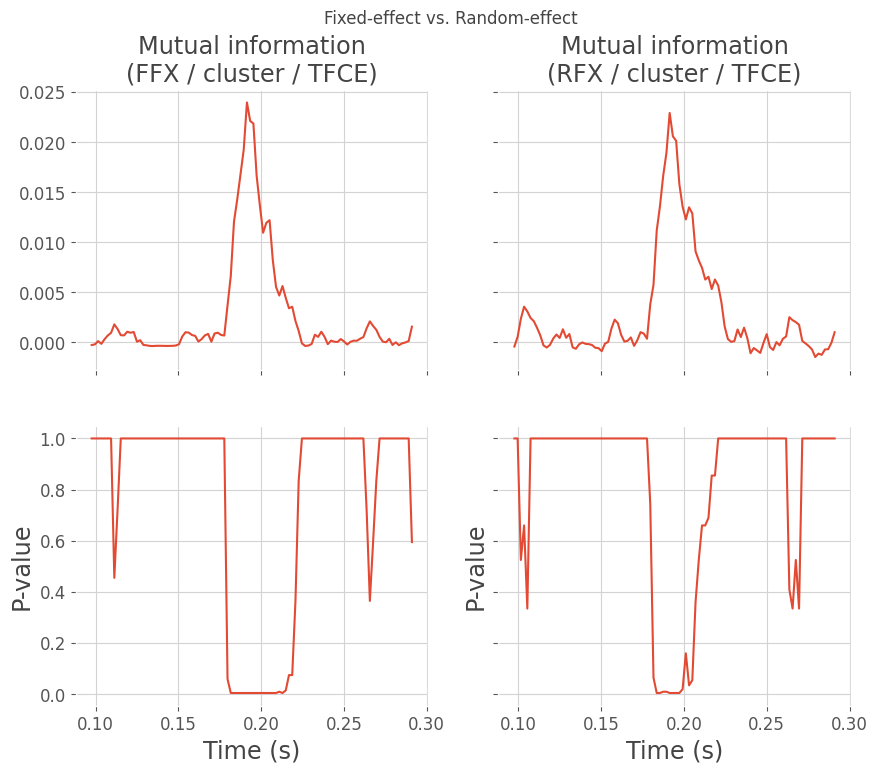

In [7]:
mi_type = "cc"
n_perm = 200
y, _ = sim_mi_cc(x, snr=0.1)

# within subject statistics (ffx=fixed-effect)
ffx_stat = "ffx_cluster_tfce"
dt_ffx = DatasetEphy(x.copy(), y=y, roi=roi, times=time)
wf_ffx = WfMi(mi_type=mi_type, inference="ffx")
mi_ffx, pv_ffx = wf_ffx.fit(
    dt_ffx, mcp="cluster", cluster_th="tfce", n_perm=n_perm, n_jobs=1
)

# between-subject statistics (rfx=random-effect)
dt_rfx = DatasetEphy(x.copy(), y=y, roi=roi, times=time)
wf_rfx = WfMi(mi_type=mi_type, inference="rfx")
mi_rfx, pv_rfx = wf_rfx.fit(
    dt_rfx, mcp="cluster", cluster_th="tfce", n_perm=n_perm, n_jobs=1
)

# plot the comparison
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey="row", figsize=(10, 8))
fig.suptitle("Fixed-effect vs. Random-effect")

plt.sca(axs[0, 0])
plt.plot(time, mi_ffx)
plt.title(f"Mutual information\n(FFX / cluster / TFCE)")
plt.sca(axs[1, 0])
plt.plot(time, pv_ffx)
plt.xlabel("Time (s)"), plt.ylabel("P-value")
plt.sca(axs[0, 1])
plt.plot(time, mi_rfx)
plt.title(f"Mutual information\n(RFX / cluster / TFCE)")
plt.sca(axs[1, 1])
plt.plot(time, pv_rfx)
plt.xlabel("Time (s)"), plt.ylabel("P-value")
plt.show()

### Continuous;Discret

In [3]:
from frites.simulations import sim_mi_cd

In [4]:
modality = "meeg"
n_subjects = 5
n_epochs = 400
n_times = 100
x, roi, time = sim_multi_suj_ephy(
    n_subjects=n_subjects,
    n_epochs=n_epochs,
    n_times=n_times,
    modality=modality,
    random_state=0,
)
x, y, _ = sim_mi_cd(x, snr=1.0, n_conditions=3)
dt = DatasetEphy(x, y=y, roi=roi, times=time)

Definition of an electrophysiological dataset
    Dataset composed of 5 subjects / sessions
    At least False subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)


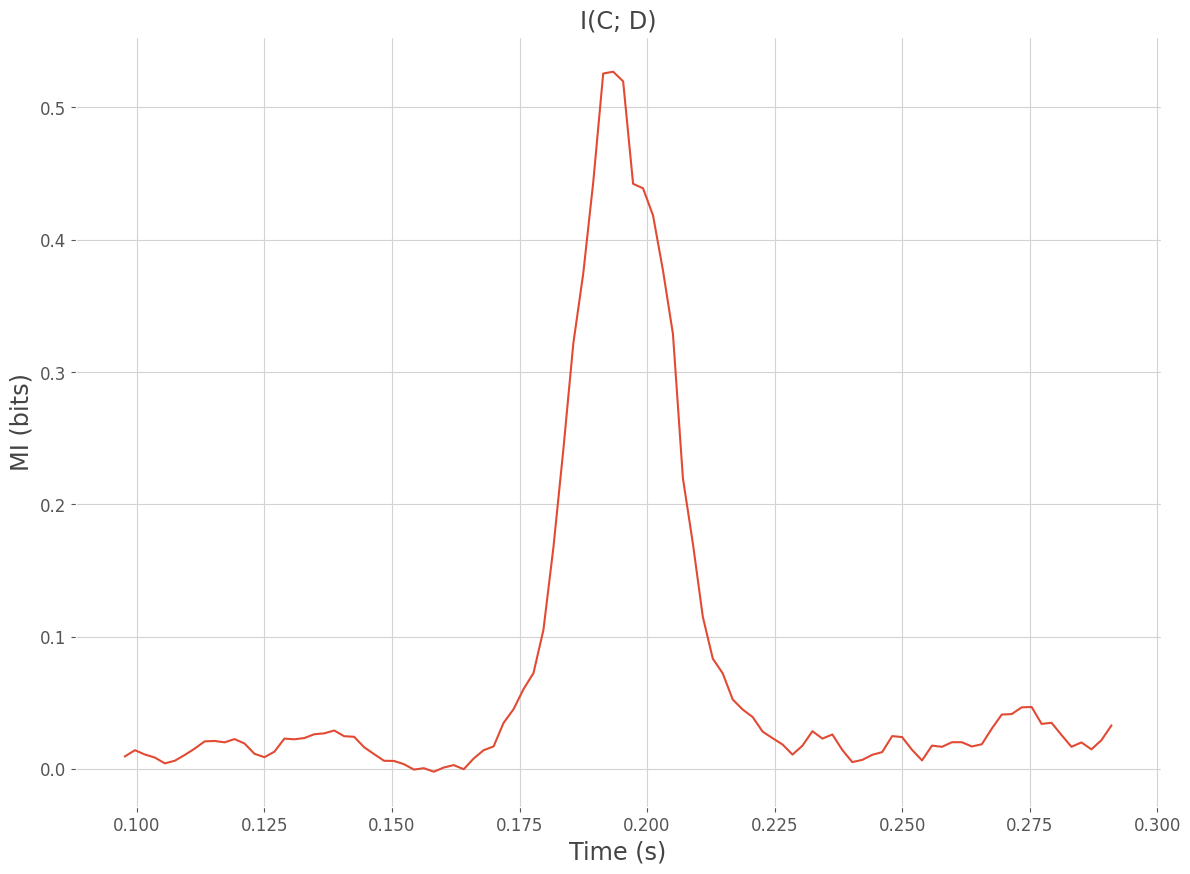

In [5]:
# mutual information type ('cd' = continuous / discret)
mi_type = "cd"

# define the workflow
wf = WfMi(mi_type=mi_type, verbose=False)
# compute the mutual information
mi, _ = wf.fit(dt, mcp=None, n_jobs=1)

# plot the information shared between the data and the regressor y
plt.plot(time, mi)
plt.xlabel("Time (s)"), plt.ylabel("MI (bits)")
plt.title("I(C; D)")
plt.show()


### Continuous;Continuous|Discret

In [13]:
from frites.simulations import sim_mi_ccd

In [14]:
modality = "meeg"
n_subjects = 5
n_epochs = 400
n_times = 100
x, roi, time = sim_multi_suj_ephy(
    n_subjects=n_subjects,
    n_epochs=n_epochs,
    n_times=n_times,
    modality=modality,
    random_state=0,
)
y, z, _ = sim_mi_ccd(x, snr=1.0)
dt = DatasetEphy(x, y=y, roi=roi, z=z, times=time)

Definition of an electrophysiological dataset
    Dataset composed of 5 subjects / sessions
    At least False subjects / roi required
    Supported MI definition I(x; y (continuous)) | z (discret) (ccd)


Gaussian Copula Mutual Information Estimator (mi_type=ccd, copnorm=False, biascorrect=True, demeaned=False)
Definition of a non-parametric statistical workflow
Workflow for computing mutual information (inference=rfx, mi_type=ccd, copnorm=True)
    Evaluate true and permuted mi (n_perm=0, n_jobs=1)
100%|██████████| Estimating MI : 1/1 [00:00<00:00,    8.69it/s]
    Mean mi across subjects


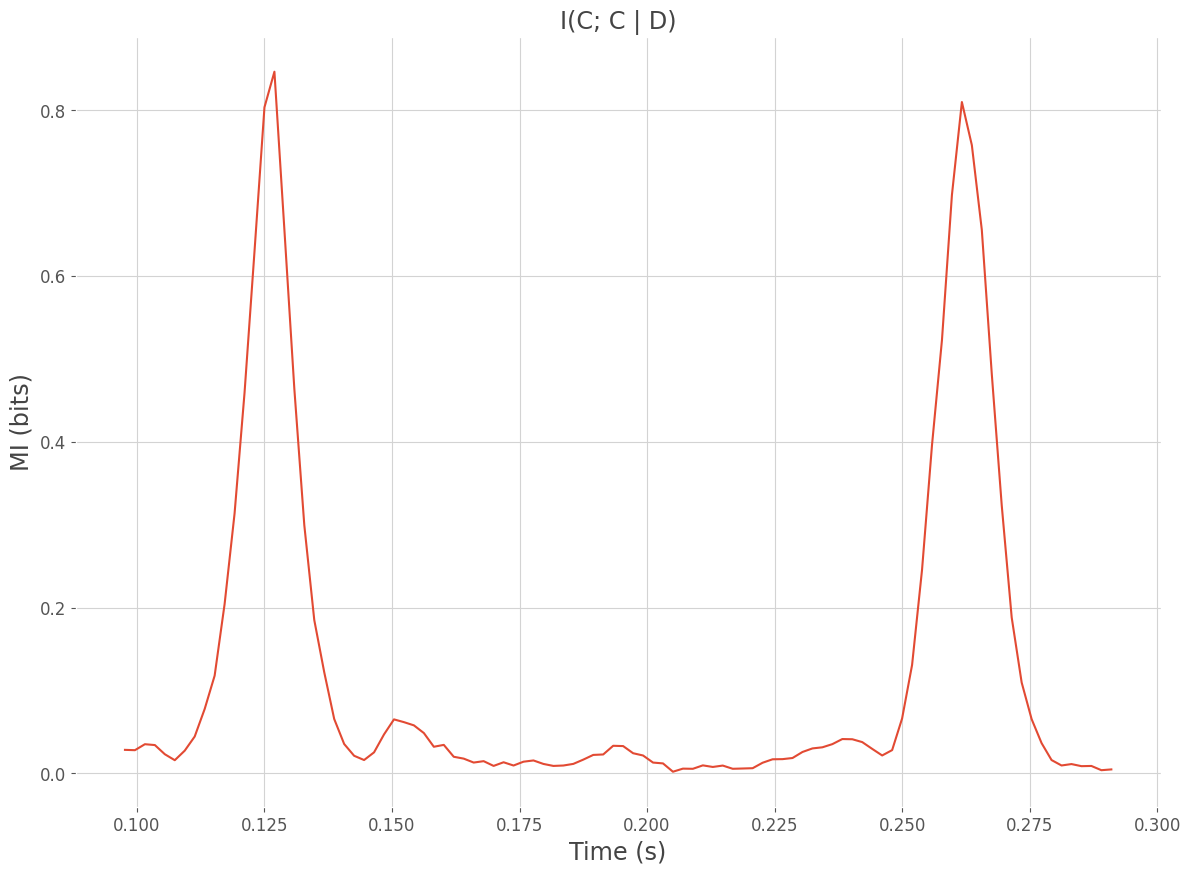

In [15]:
# mutual information type ('ccd' = continuous; continuous | discret)
mi_type = "ccd"

# define the workflow
wf = WfMi(mi_type=mi_type)
# compute the mutual information
mi, _ = wf.fit(dt, mcp=None, n_jobs=1)

# plot the information shared between the data and the regressor y
plt.plot(time, mi)
plt.xlabel("Time (s)"), plt.ylabel("MI (bits)")
plt.title("I(C; C | D)")
plt.show()


### MI across time and frequencies

In [3]:
n_subjects = 5
n_freqs = 20
n_times = 50
n_trials = np.random.randint(50, 100, n_subjects)

In [4]:
def sim_single_subject(n_freqs, n_times, n_trials, noise_level=10.0):
    # generate the mask modulating the amplitude of the gaussian
    t_range, f_range = np.linspace(-1, 1, n_times), np.linspace(-1, 1, n_freqs)
    x, y = np.meshgrid(t_range, f_range)
    d = np.sqrt(x * x + y * y)
    sigma, mu = 2.0, 0.0
    mask_2d = np.exp(-((d - mu) ** 0.5 / (2.0 * sigma**0.5)))
    # [0, 1] normalize the mask
    mask_2d -= mask_2d.min()
    mask_2d /= mask_2d.max()
    # turn the mask 3d
    mask_3d = np.tile(mask_2d[np.newaxis, ...], (n_trials, 1, 1))
    # generate the base data
    noise = np.random.uniform(0, noise_level, (n_trials, 1, 1))
    gauss = np.random.normal(0, 1, (n_trials))
    y = gauss.copy()
    gauss = np.tile(gauss.reshape(-1, 1, 1), (1, n_freqs, n_times))
    # data is finally defined as util signal + noise
    data = noise + gauss * mask_3d

    return data[:, np.newaxis, ...], y


In [5]:
x, y, roi = [], [], []
times = np.linspace(-1, 1, n_times)
freqs = np.linspace(60, 160, n_freqs)
for s, tr in zip(range(n_subjects), n_trials):
    # simulate the data coming from a single subject
    x_single_suj, y_single_suj = sim_single_subject(n_freqs, n_times, tr)
    # xarray conversion
    _x = xr.DataArray(
        x_single_suj,
        dims=("trials", "roi", "freqs", "times"),
        coords=(y_single_suj, ["roi_0"], freqs, times),
    )
    x += [_x]

# define an instance of DatasetEphy
ds = DatasetEphy(x, y="trials", roi="roi", times="times")

Definition of an electrophysiological dataset
    Dataset composed of 5 subjects / sessions
    At least False subjects / roi required
    Supported MI definition I(x; y (continuous)) (cc)


Gaussian Copula Mutual Information Estimator (mi_type=cc, copnorm=False, biascorrect=True, demeaned=False)
Definition of a non-parametric statistical workflow
Workflow for computing mutual information (inference=ffx, mi_type=cc, copnorm=True)
    Evaluate true and permuted mi (n_perm=200, n_jobs=1)
c:\Users\chris\Documents\cflab\itpg\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| Estimating MI : 1/1 [00:01<00:00,    1.26s/it]
    Fixed-effect inference (FFX)
    Cluster forming threshold (tail=1; alpha=0.05; tfce=None)
    Inference at cluster-level
    Cluster detection (threshold=0.004862661007791758; tail=1)


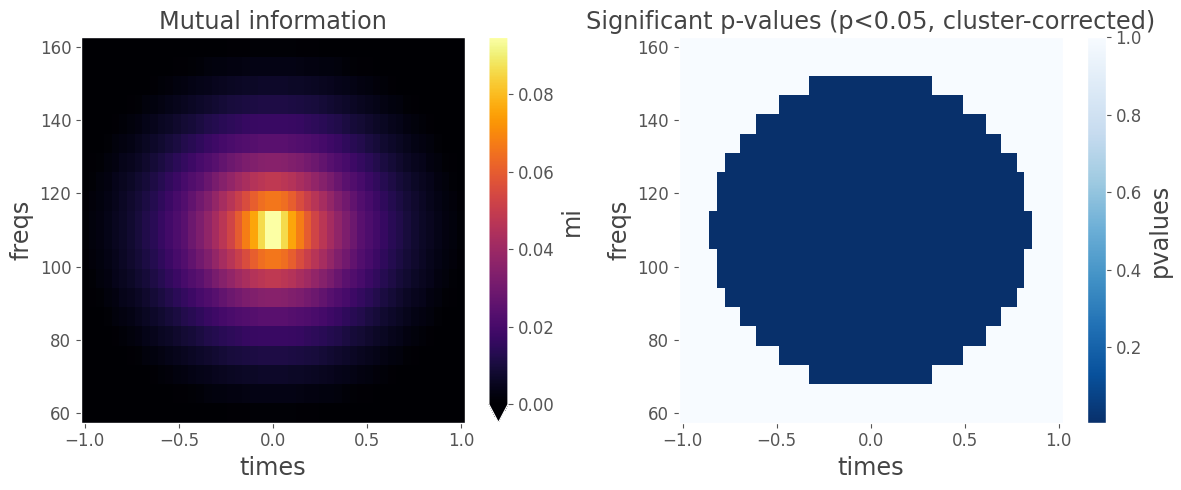

In [6]:
# compute the mutual information
wf = WfMi(inference="ffx", mi_type="cc")
mi, pv = wf.fit(ds, n_perm=200, mcp="cluster", random_state=0, n_jobs=1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
mi.squeeze().plot.pcolormesh(vmin=0, cmap="inferno")
plt.title("Mutual information")
plt.subplot(1, 2, 2)
pv.squeeze().plot.pcolormesh(cmap="Blues_r")
plt.title("Significant p-values (p<0.05, cluster-corrected)")
plt.tight_layout()


### MI at the contact level

#### Continuous;Continuous

Definition of an electrophysiological dataset
    Dataset composed of 3 subjects / sessions
    At least False subjects / roi required
    Supported MI definition I(x; y (continuous)) (cc)
Gaussian Copula Mutual Information Estimator (mi_type=cc, copnorm=False, biascorrect=True, demeaned=False)
Definition of a non-parametric statistical workflow
Workflow for computing mutual information (inference=rfx, mi_type=cc, copnorm=True)
    Evaluate true and permuted mi (n_perm=0, n_jobs=-1)
100%|██████████| Estimating MI : 1/1 [00:00<00:00,   36.85it/s]
    Mean mi across subjects
Definition of an electrophysiological dataset
    Dataset composed of 3 subjects / sessions
    At least False subjects / roi required
    Supported MI definition I(x; y (continuous)) (cc)
Gaussian Copula Mutual Information Estimator (mi_type=ccd, copnorm=False, biascorrect=True, demeaned=False)
Definition of a non-parametric statistical workflow
Workflow for computing mutual information (inference=rfx, mi_type=ccd, 

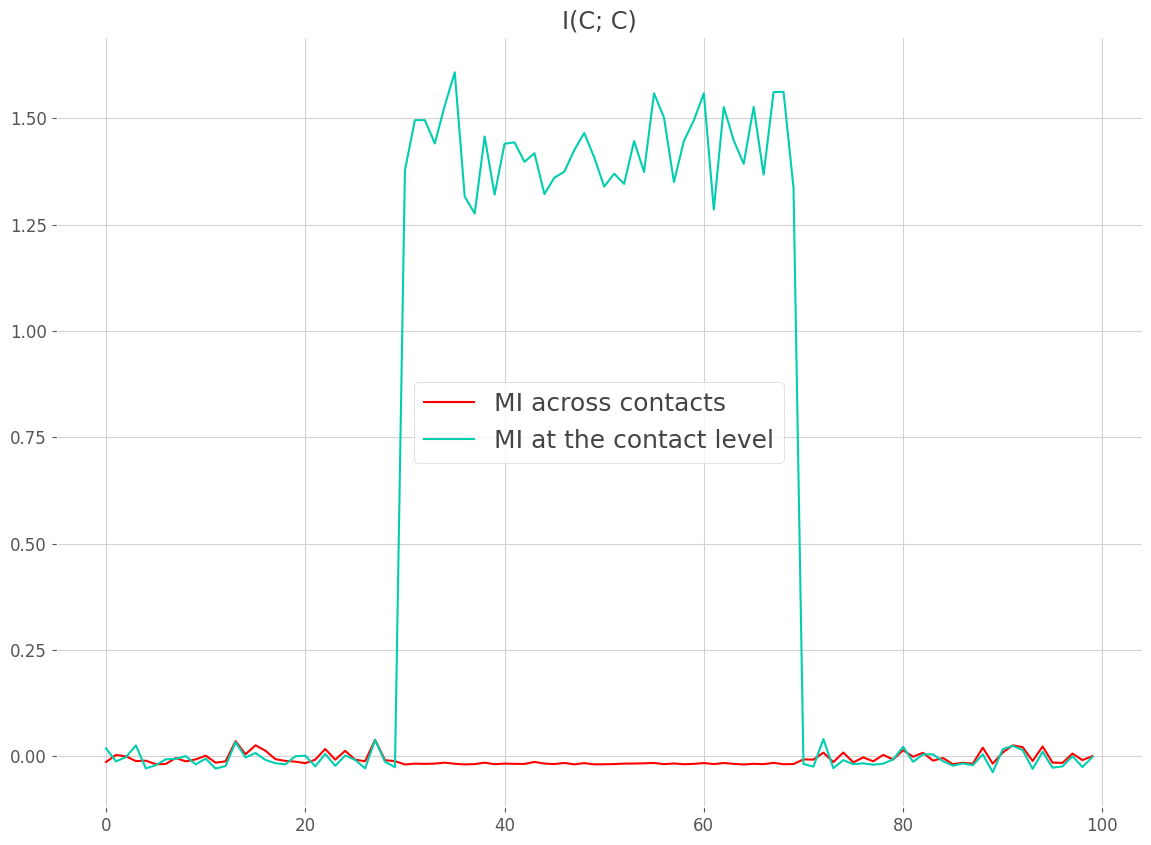

In [25]:
n_suj = 3
n_trials = 20
n_times = 100
half = int(n_trials / 2)
times = np.arange(n_times)

x, y, roi = [], [], []
for suj in range(n_suj):
    # initialize subject's data with random noise
    _x = np.random.rand(n_trials, 2, n_times)
    # normal continuous regressor
    _y = np.random.normal(size=(n_trials,))

    # first contact has positive correlations
    _x[:, 0, slice(30, 70)] += _y.reshape(-1, 1)
    # second contact has negative correlations
    _x[:, 1, slice(30, 70)] -= _y.reshape(-1, 1)

    x += [_x]
    y += [_y]
    roi += [np.array(["roi_0", "roi_0"])]

# now, compute the mi with default parameters
ds = DatasetEphy(x, y=y, roi=roi, times=times, agg_ch=True)
mi = WfMi(mi_type="cc").fit(ds, mcp="noperm")[0]

# compute the mi at the contact level
ds = DatasetEphy(x, y=y, roi=roi, times=times, agg_ch=False)
mi_c = WfMi(mi_type="ccd").fit(ds, mcp="noperm")[0]

# plot the comparison
plt.figure()
plt.plot(times, mi, label="MI across contacts")
plt.plot(times, mi_c, label="MI at the contact level")
plt.legend()
plt.title("I(C; C)")
plt.show()


Definition of an electrophysiological dataset
    Dataset composed of 3 subjects / sessions
    At least False subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)
Gaussian Copula Mutual Information Estimator (mi_type=cd, copnorm=False, biascorrect=True, demeaned=False)
Definition of a non-parametric statistical workflow
Workflow for computing mutual information (inference=rfx, mi_type=cd, copnorm=True)
    Evaluate true and permuted mi (n_perm=0, n_jobs=-1)
100%|██████████| Estimating MI : 1/1 [00:00<00:00,   17.70it/s]
    Mean mi across subjects
Definition of an electrophysiological dataset
    Dataset composed of 3 subjects / sessions
    At least False subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)
Gaussian Copula Mutual Information Estimator (mi_type=cd, copnorm=False, biascorrect=True, demeaned=False)
Definition of a non-parametric statistical workflow
Workflow for computing mutual information (inference=rfx, mi_type=cd, copnorm=

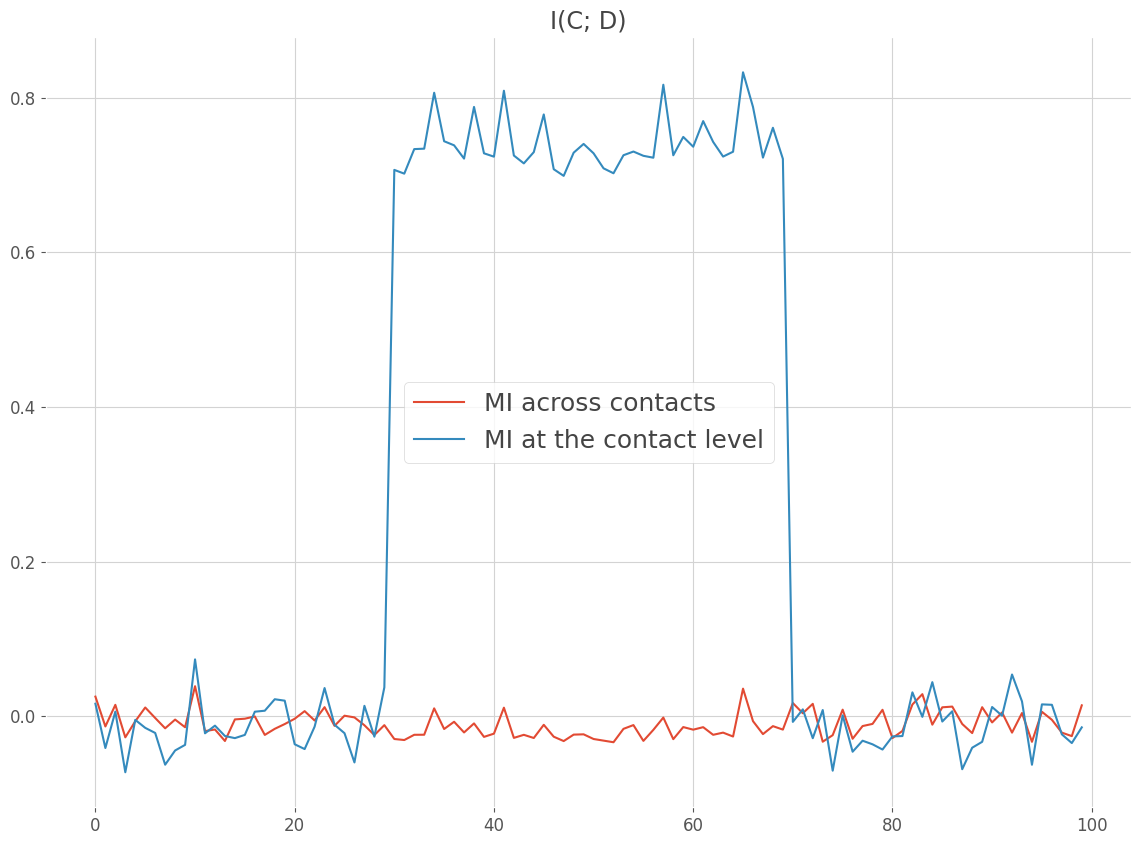

In [8]:
n_suj = 3
n_trials = 20
n_times = 100
half = int(n_trials / 2)
times = np.arange(n_times)

x, y, roi = [], [], []
for suj in range(n_suj):
    # initialize subject's data with random noise
    _x = np.random.rand(n_trials, 2, n_times)
    # define a positive and negative offsets of 1
    _y_pos, _y_neg = np.full((half, 1), 1.0), np.full((half, 1), -1.0)

    # first contact / first half trials : positive offset
    _x[0:half, 0, slice(30, 70)] += _y_pos
    # first contact / second half trials : negative offset
    _x[half::, 0, slice(30, 70)] += _y_neg
    # second contact / first half trials : negative offset
    _x[0:half, 1, slice(30, 70)] += _y_neg
    # second contact / second half trials : positive offset
    _x[half::, 1, slice(30, 70)] += _y_pos

    x += [_x]
    y += [np.array([0] * half + [1] * half)]
    roi += [np.array(["roi_0", "roi_0"])]
times = np.arange(n_times)

# now, compute the mi with default parameters
ds = DatasetEphy(x, y=y, roi=roi, times=times)
mi = WfMi(mi_type="cd").fit(ds, mcp="noperm")[0]

# compute the mi at the contact level
ds = DatasetEphy(x, y=y, roi=roi, times=times, agg_ch=False)
mi_c = WfMi(mi_type="cd").fit(ds, mcp="noperm")[0]

# plot the comparison
plt.figure()
plt.plot(times, mi, label="MI across contacts")
plt.plot(times, mi_c, label="MI at the contact level")
plt.legend()
plt.title("I(C; D)")
plt.show()


#### Continuous;Continuous|Discret

Definition of an electrophysiological dataset
    Dataset composed of 3 subjects / sessions
    At least False subjects / roi required
    Supported MI definition I(x; y (continuous)) | z (discret) (ccd)
Gaussian Copula Mutual Information Estimator (mi_type=ccd, copnorm=False, biascorrect=True, demeaned=False)
Definition of a non-parametric statistical workflow
Workflow for computing mutual information (inference=rfx, mi_type=ccd, copnorm=True)
    Evaluate true and permuted mi (n_perm=0, n_jobs=-1)
100%|██████████| Estimating MI : 1/1 [00:00<00:00,   31.36it/s]
    Mean mi across subjects
Definition of an electrophysiological dataset
    Dataset composed of 3 subjects / sessions
    At least False subjects / roi required
    Supported MI definition I(x; y (continuous)) | z (discret) (ccd)
Gaussian Copula Mutual Information Estimator (mi_type=ccd, copnorm=False, biascorrect=True, demeaned=False)
Definition of a non-parametric statistical workflow
Workflow for computing mutual informati

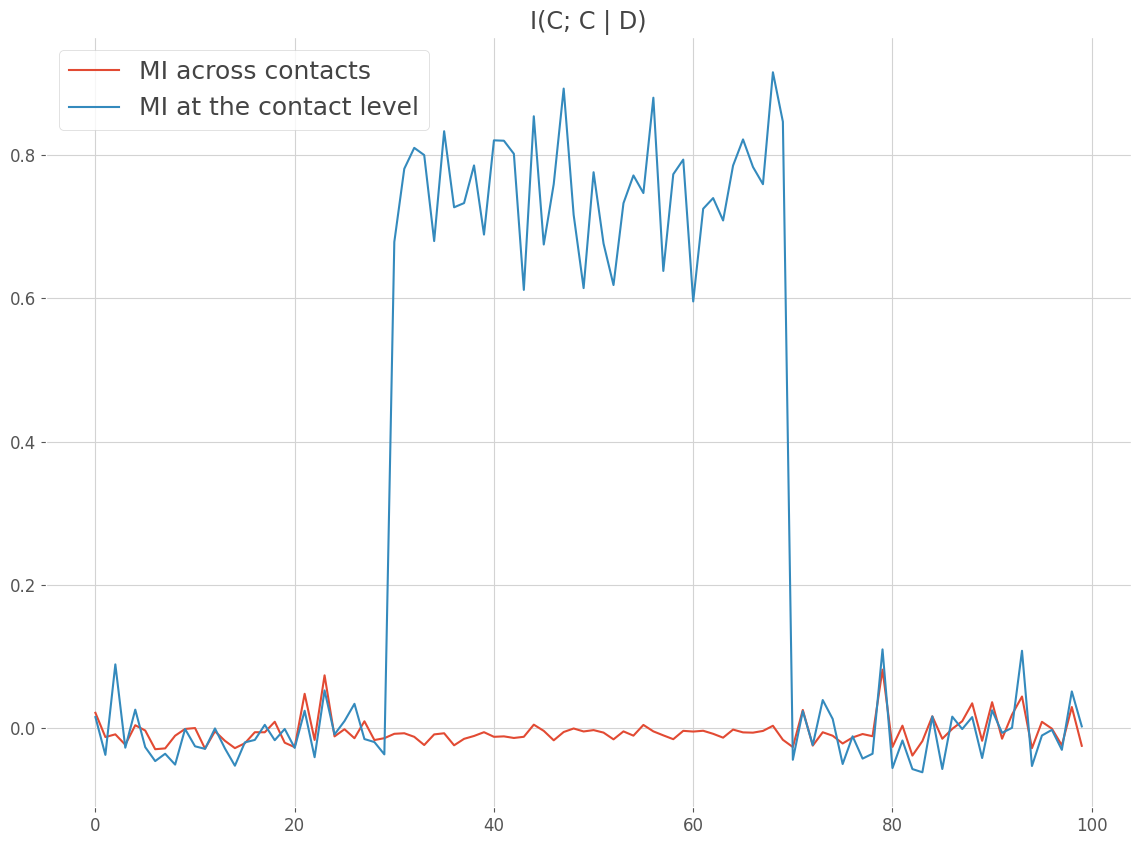

In [11]:
x, y, z, roi = [], [], [], []
for suj in range(n_suj):
    # initialize subject's data with random noise
    _x = np.random.rand(n_trials, 2, n_times)
    # define a positive and negative correlations
    _y_pos = np.random.normal(loc=1, size=(half))
    _y_neg = np.random.normal(loc=-1, size=(half))
    _y = np.r_[_y_pos, _y_neg]
    _z = np.array([0] * half + [1] * half)

    # first contact / first half trials : positive offset
    _x[0:half, 0, slice(30, 70)] += _y_pos.reshape(-1, 1)
    # first contact / second half trials : negative offset
    _x[half::, 0, slice(30, 70)] += _y_neg.reshape(-1, 1)
    # second contact / first half trials : negative offset
    _x[0:half, 1, slice(30, 70)] += _y_neg.reshape(-1, 1)
    # second contact / second half trials : positive offset
    _x[half::, 1, slice(30, 70)] += _y_pos.reshape(-1, 1)

    x += [_x]
    y += [_y]
    z += [_z]
    roi += [np.array(["roi_0", "roi_0"])]
times = np.arange(n_times)

# now, compute the mi with default parameters
ds = DatasetEphy(x, y=y, z=z, roi=roi, times=times)
mi = WfMi(mi_type="ccd").fit(ds, mcp="noperm")[0]

# compute the mi at the contact level
ds = DatasetEphy(x, y=y, z=z, roi=roi, times=times, agg_ch=False)
mi_c = WfMi(mi_type="ccd").fit(ds, mcp="noperm")[0]

# plot the comparison
plt.figure()
plt.plot(times, mi, label="MI across contacts")
plt.plot(times, mi_c, label="MI at the contact level")
plt.legend()
plt.title("I(C; C | D)")
plt.show()


## Dynamical functional connectivity

In [2]:
modality = "meeg"
n_roi = 3
n_epochs = 50
n_times = 1000
x, roi, _ = sim_single_suj_ephy(
    n_epochs=n_epochs, n_times=n_times, modality=modality, n_roi=n_roi, random_state=0
)

times = np.linspace(-1, 1, n_times)


In [3]:
x[:, [1], slice(100, 400)] += x[:, [0], slice(100, 400)]
x[:, [2], slice(600, 800)] += x[:, [1], slice(600, 800)]
print(f"Corr 1 : {roi[0]}-{roi[1]} between [{times[100]}-{times[400]}]")
print(f"Corr 2 : {roi[2]}-{roi[1]} between [{times[600]}-{times[800]}]")


Corr 1 : L_VCcm-L_VCl between [-0.7997997997997999--0.19919919919919926]
Corr 2 : L_VCs-L_VCl between [0.20120120120120122-0.6016016016016015]


In [4]:
slwin_len = 0.1
slwin_step = 0.02
win_sample = define_windows(times, slwin_len=slwin_len, slwin_step=slwin_step)[0]
times_p = times[win_sample].mean(1)

Defining temporal windows (sfreq=499.50000000001125)
    Definition of sliding windows (len=0.1, start=-1.0, stop=1.0, step=0.02)


Defining links (n_roi=3; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Gaussian Copula Mutual Information Estimator (mi_type=cc, copnorm=False, biascorrect=False, demeaned=False)
Computing DFC between 3 pairs (gcrn=False)
c:\Users\chris\Documents\cflab\itpg\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| Estimating DFC : 3/3 [00:00<00:00,   26.08it/s]


<xarray.DataArray 'DFC (Gaussian Copula Mutual Information Estimator)' (
                                                                        trials: 50,
                                                                        roi: 3,
                                                                        times: 95)>
array([[[4.74126835e-04, 4.86970457e-05, 1.15753941e-01, ...,
         1.44106135e-01, 1.00405946e-01, 8.37376192e-02],
        [3.29334080e-01, 3.09351981e-01, 7.13511854e-02, ...,
         6.81263686e-04, 2.51765386e-03, 3.19818184e-02],
        [9.04738065e-03, 2.04119571e-02, 2.55241338e-02, ...,
         6.54823380e-03, 1.80942327e-01, 7.69555792e-02]],

       [[2.43588135e-01, 4.48731631e-02, 3.06968745e-02, ...,
         1.19652078e-02, 1.41519258e-05, 1.56958587e-02],
        [1.19740553e-01, 4.07272950e-02, 1.60232615e-02, ...,
         4.46936190e-02, 5.86355664e-02, 7.60393683e-04],
        [1.73070922e-01, 1.90565914e-01, 3.83086987e-02, ...,
         1.1654

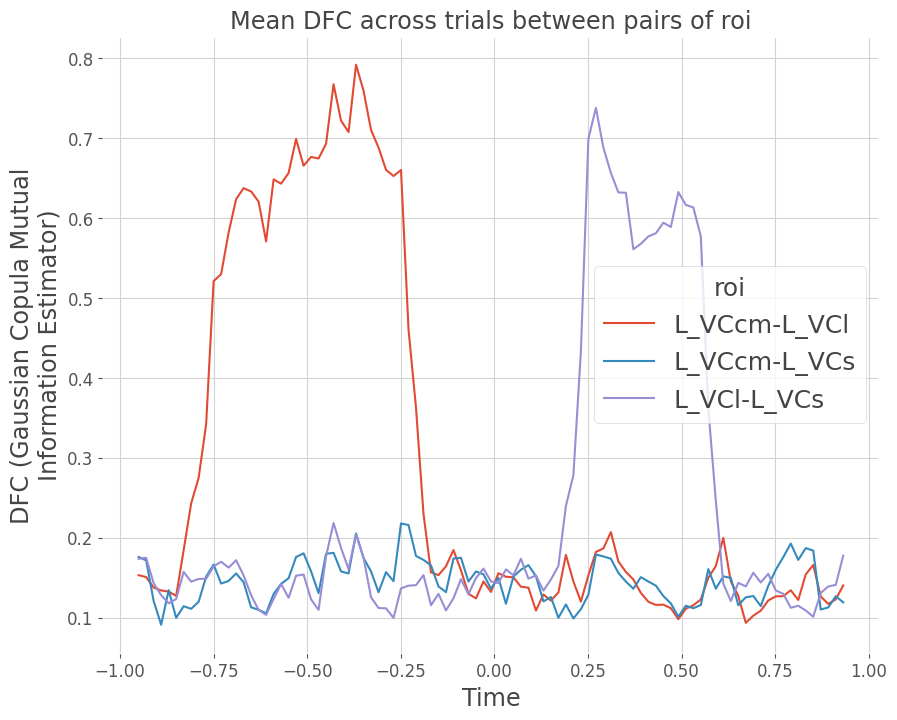

In [5]:
dfc = conn_dfc(x, win_sample, times=times, roi=roi, n_jobs=1)
print(dfc)

plt.figure(figsize=(10, 8))
# plt.plot(times_p, dfc.mean('trials').T)
dfc.mean("trials").plot.line(x="times", hue="roi")
plt.xlabel("Time")
plt.title("Mean DFC across trials between pairs of roi")
plt.show()
